In [1]:
cd ..

/home/wesg/research/ordinal-probing


In [2]:
# autoreload
%load_ext autoreload
%autoreload 2

import numpy as np
import sklearn
import pandas as pd
import matplotlib.pyplot as plt
import torch
from scipy.stats import rankdata
from load import load_model
import datasets
import seaborn as sns

from feature_datasets.common import *
import utils
import os

from probe_experiment import load_probe_results
from analysis.generalization import*
from analysis.probe_plots import *

%matplotlib inline

In [3]:
experiment_name = 'test_refactor'
model_name = 'Llama-2-7b-hf'
entity_type = 'world_place'
feature_name = 'coords'
prompt = 'coords'
probe_result = load_probe_results(experiment_name, model_name, entity_type, feature_name, prompt)

In [4]:
models = ['Llama-2-7b-hf', 'Llama-2-13b-hf', 'Llama-2-70b-hf']
prompts = ['empty', 'describe', 'where_is', 'coords']
#prompts = ['where_nyc', 'where_is', 'where_nyc_normalized']

In [5]:
rdf = make_result_df(models, prompts, experiment_name, entity_type, feature_name)

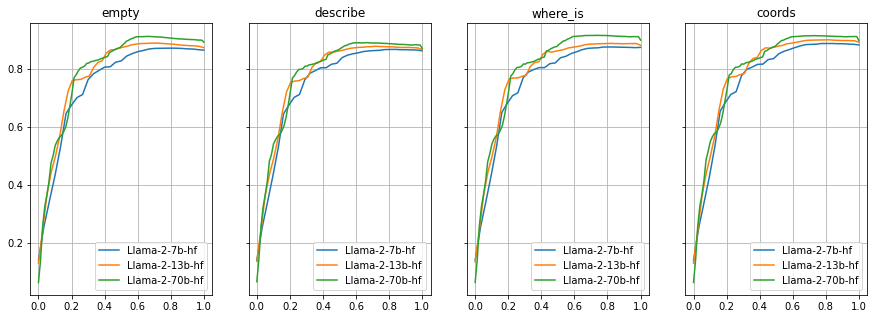

In [6]:
performance_by_prompt(rdf, prompts, models);

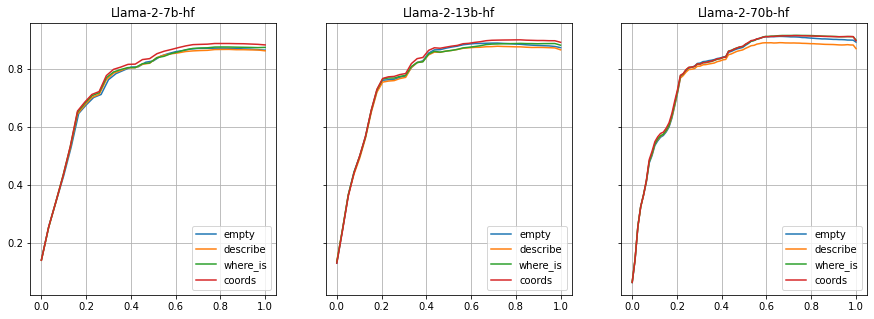

In [7]:
performance_by_model(rdf, prompts, models);

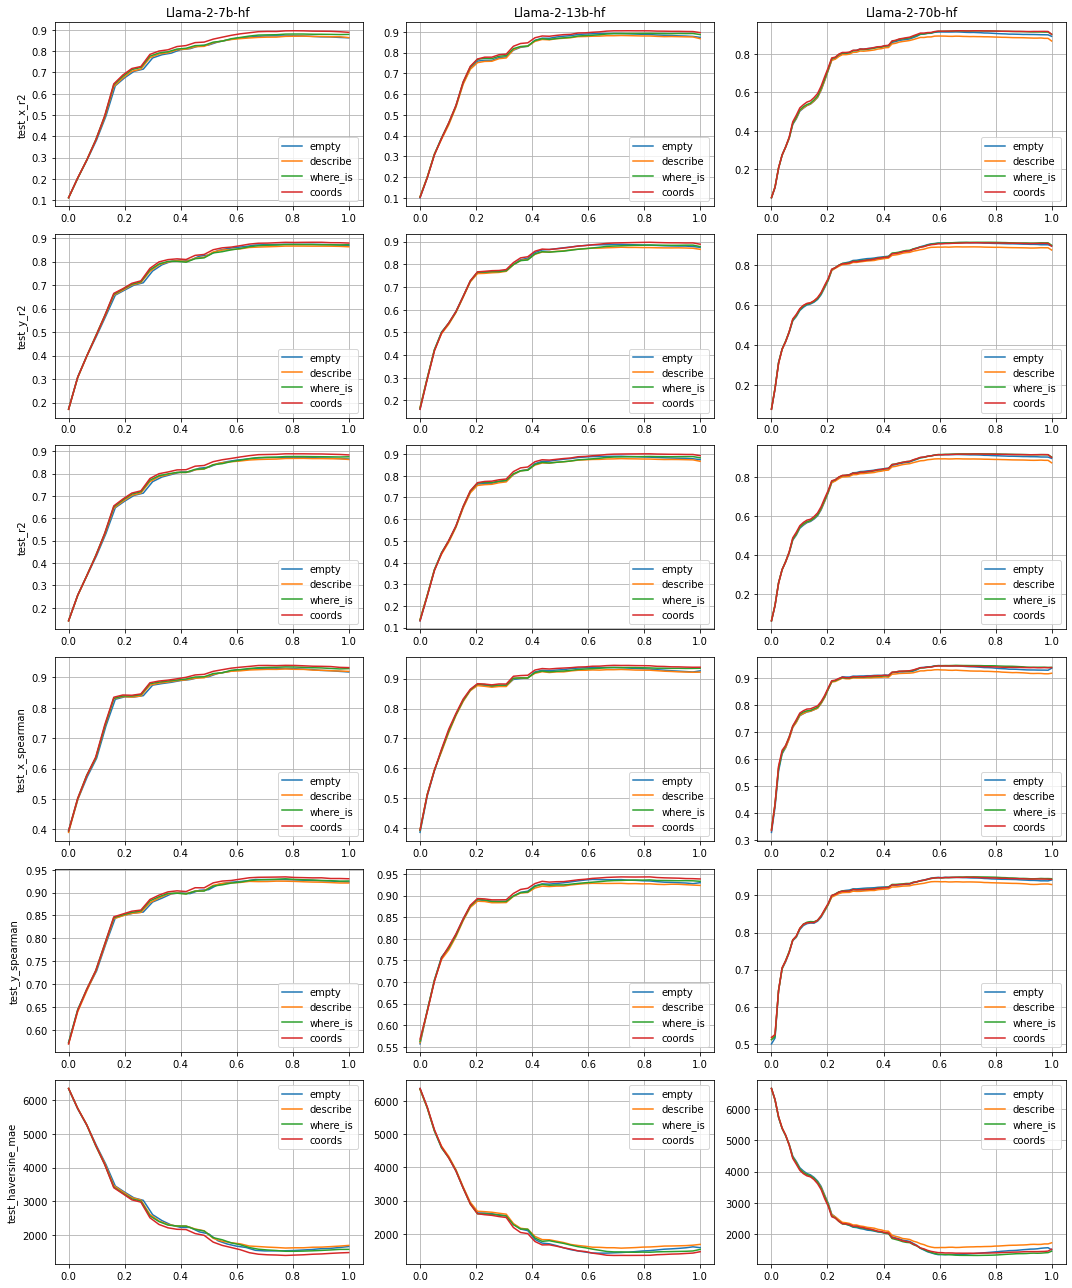

In [8]:
metrics = ['test_x_r2', 'test_y_r2', 'test_r2', 'test_x_spearman', 'test_y_spearman', 'test_haversine_mae']
performance_by_model_multiple_metrics(rdf, prompts, models, metrics=metrics);

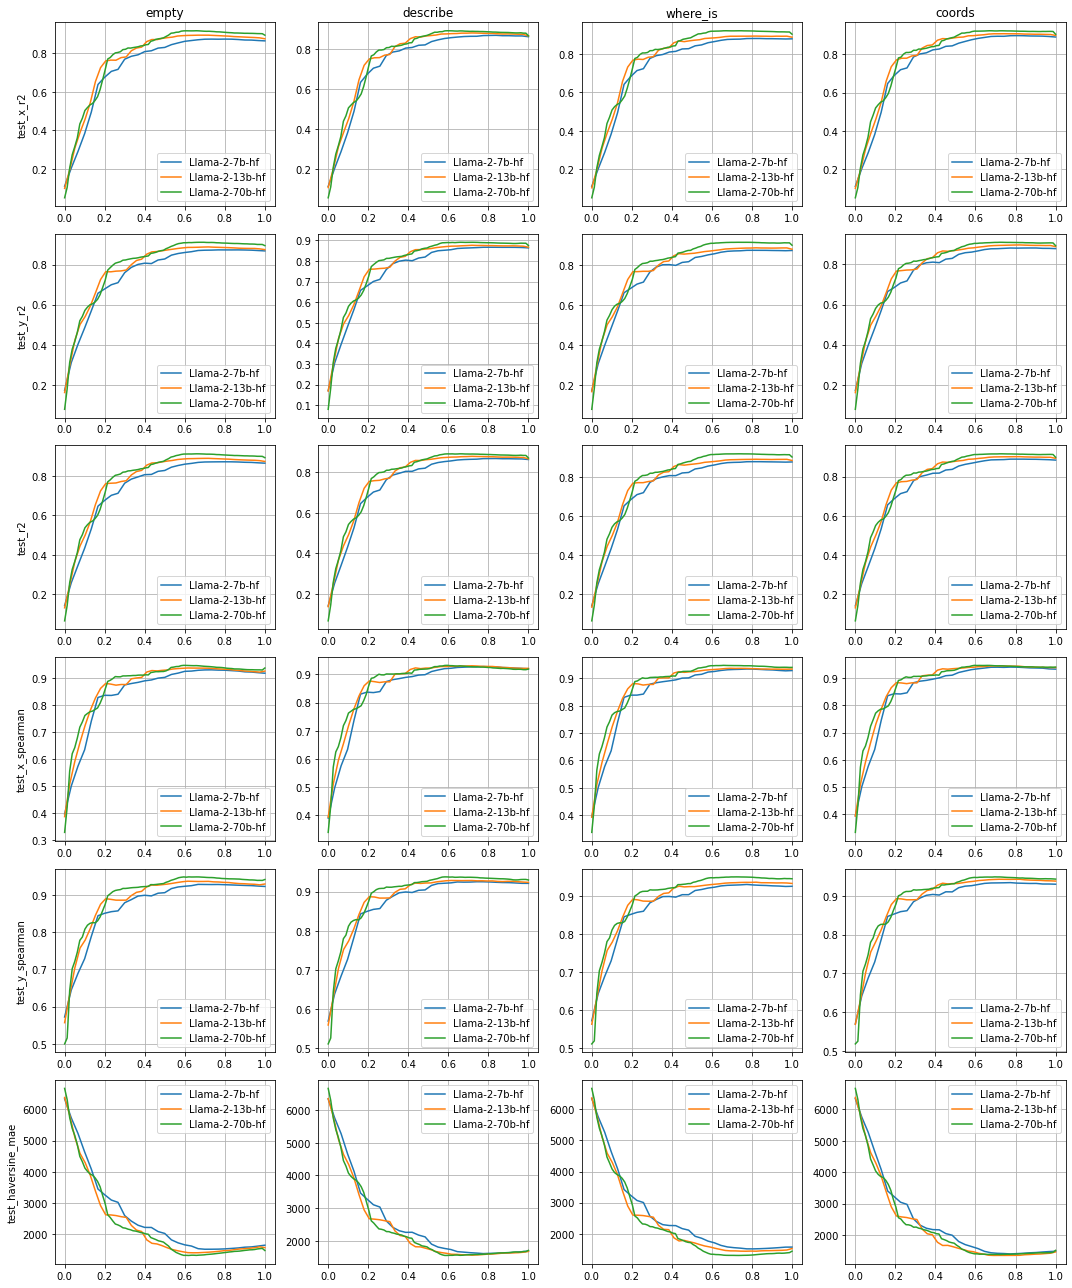

In [15]:
metrics = ['test_x_r2', 'test_y_r2', 'test_r2', 'test_x_spearman', 'test_y_spearman', 'test_haversine_mae']
performance_by_prompt_multiple_metrics(rdf, prompts, models, metrics=metrics);

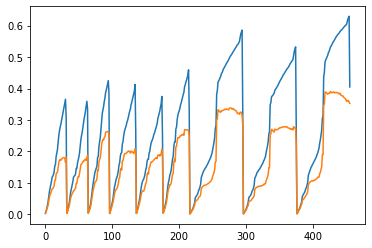

In [119]:
plt.plot(rdf[('train_r2')])
plt.plot(rdf[('test_r2')])

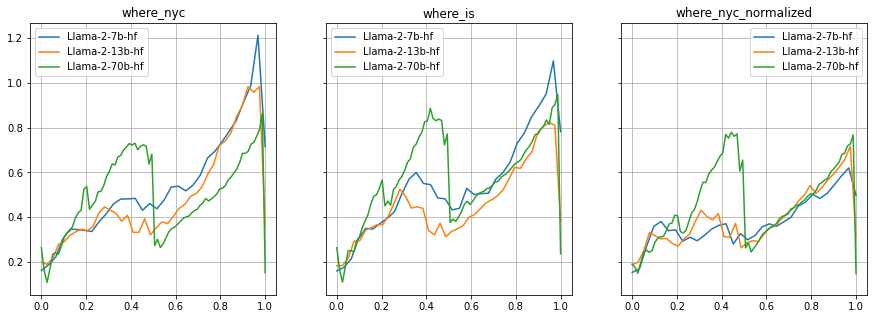

In [120]:
# plot the difference between train and test r^2
normalize_layer = True
fig, axs = plt.subplots(1, len(prompts), figsize=(15, 5), sharey=True)
for i, prompt in enumerate(prompts):
    ax = axs[i]
    for model in models:
        data_df = rdf[(rdf.model == model) & (rdf.prompt==prompt)]
        layer = data_df.layer.values
        if normalize_layer:
            layer = layer / layer.max()
        ax.plot(layer, (data_df['train_r2'] - data_df['test_r2']) / data_df['test_r2'], label=model)
    ax.set_title(prompt)
    ax.legend()
    ax.grid()


In [11]:
model_directions = make_probe_direction_matrices(models, prompts, experiment_name, entity_type, feature_name)
plot_probe_cosine_sim(model_directions, models, prompts, feature_dim=0)

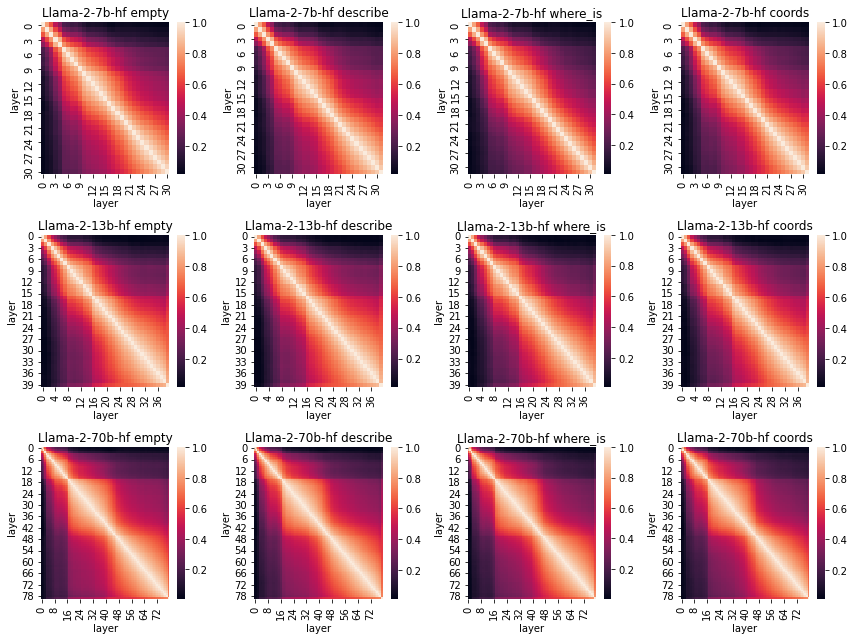

In [23]:
from sklearn.metrics.pairwise import cosine_similarity 

n_rows, n_cols = len(models), len(prompts)
fig, axs = plt.subplots(n_rows, n_cols, figsize=(n_cols * 3, n_rows * 3))
for m_ix, model in enumerate(models):
    for p_jx, prompt in enumerate(prompts):
        ax = axs[m_ix, p_jx]
        directions = model_directions[model, prompt][:, :, 0]
        similarities = cosine_similarity(directions)
        sns.heatmap(similarities, ax=ax)
        ax.set_title(f'{model} {prompt}')
        ax.set_xlabel('layer')
        ax.set_ylabel('layer')
plt.tight_layout()

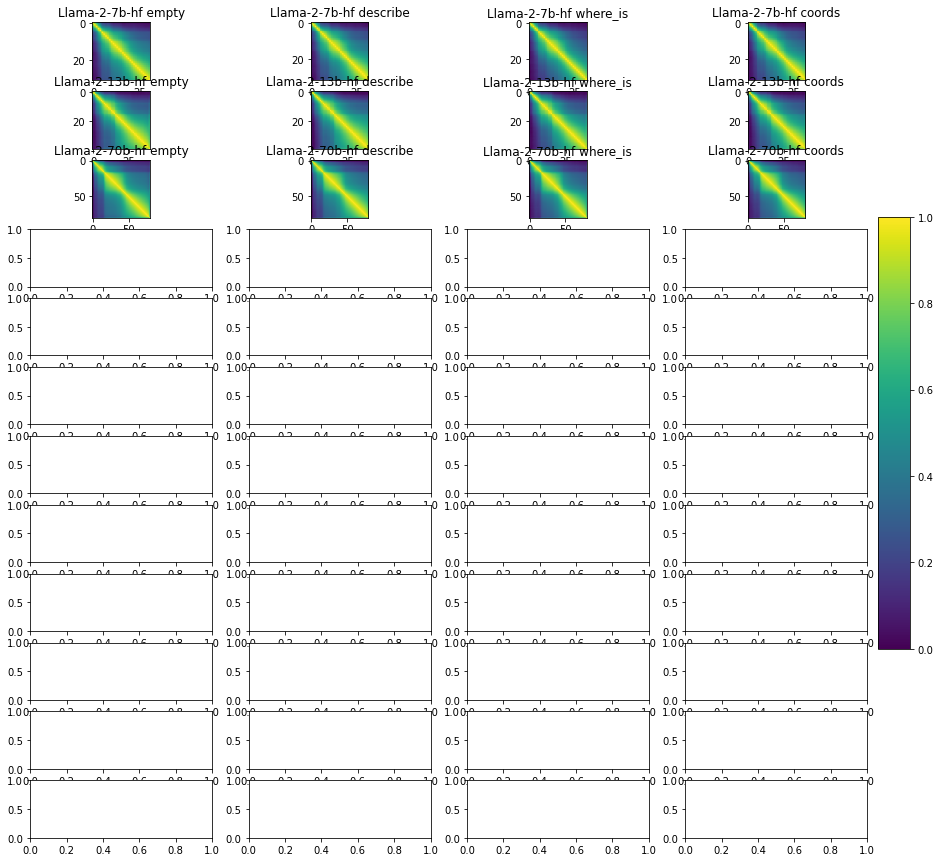

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity


row = 0
col = 0
max_p = len(set([p for (m, p) in model_directions.keys()]))
current_m = None

fig, axes = plt.subplots(len(model_directions), max_p, figsize=(15, 15))
cbar_ax = fig.add_axes([.91, .3, .03, .4])

for (m, p), mat in model_directions.items():
    if current_m is None:
        current_m = m
    
    if m != current_m:
        row += 1
        col = 0
        current_m = m
    
    cos = cosine_similarity(mat[:, :, 0])
    
    im = axes[row, col].imshow(cos, vmin=0, vmax=1)
    axes[row, col].set_title(f'{m} {p}')
    
    col += 1

fig.colorbar(im, cax=cbar_ax)
plt.show()


In [18]:
model_directions = np.stack(list(probe_result['probe_directions'].values()))

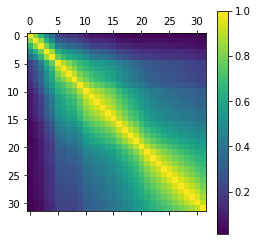

In [19]:
# import cosine sm
from sklearn.metrics.pairwise import cosine_similarity 
plt.matshow(cosine_similarity(model_directions[:, :, 0]))
plt.colorbar()

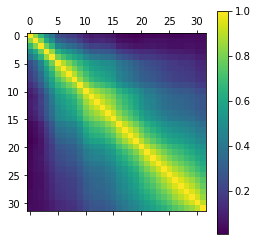

In [20]:
plt.matshow(cosine_similarity(model_directions[:, :, 1]))
# add colorbar
plt.colorbar()

In [42]:
probe_result['projections'][0]

,x,y,is_test,x_error,y_error
0,27.915763,14.386824,False,43.717463,62.247124
1,28.024851,6.064077,False,20.587911,-74.635623
2,25.859539,20.181397,False,-16.452561,103.358097
3,27.850941,18.901549,False,-25.149059,13.734879
4,27.366833,13.728348,True,-6.433967,-21.998752
...,...,...,...,...,...
39580,27.973390,5.907302,False,-12.499910,111.732302
39581,28.172509,17.329401,True,-22.310491,137.806401
39582,28.338403,15.340149,True,-45.411597,-93.659851
39583,28.188269,23.514439,True,30.271599,-85.152561


In [4]:
from feature_datasets import common

In [125]:
entity_df = common.load_entity_data('headline')
entity_df

,Unnamed: 0,headline,word_count,pub_date,print_section,print_page,section,news_desk,year,is_trump,is_biden,is_coronavirus,is_covid,is_obama,is_clinton,is_iraq,is_afghanistan,is_china,is_iran,is_test
0,28,C.I.A. Takes On Bigger and Riskier Role on Fro...,1018,2010-01-01T01:57:51+0000,A,1,World,Foreign,2010,False,False,False,False,False,False,False,False,False,False,False
1,90,Bomb Takes Heavy Toll at Pakistan Sports Event.,968,2010-01-01T08:41:24+0000,A,1,World,Foreign,2010,False,False,False,False,False,False,False,False,False,False,False
2,108,Standoff in Iran Deepens With New Show of Force.,1102,2010-01-01T16:22:24+0000,A,4,World,Foreign,2010,False,False,False,False,False,False,False,False,False,True,False
3,181,Different Taliban Groups Claim Role in Afghani...,582,2010-01-02T00:36:05+0000,A,4,World,Foreign,2010,False,False,False,False,False,False,False,True,False,False,False
4,215,Fragile Calm Holds in Darfur After Years of De...,1084,2010-01-02T01:55:56+0000,A,1,World,Foreign,2010,False,False,False,False,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28384,55028,"Phil Niekro, Hall of Fame Knuckleball Pitcher,...",1014,2020-12-27T19:27:24+0000,B,8,Obituaries,Obits,2020,False,False,False,False,False,False,False,False,False,False,True
28385,55125,"H. Jack Geiger, Doctor Who Fought Social Ills,...",2213,2020-12-28T20:17:11+0000,B,9,Health,Obits,2020,False,False,False,False,False,False,False,False,False,False,False
28386,55199,"Pierre Cardin, Designer to the Famous and Merc...",2703,2020-12-29T12:26:54+0000,A,1,Style,Obits,2020,False,False,False,False,False,False,False,False,False,False,False
28387,55260,"Howard J. Rubenstein, Public Relations Impresa...",1650,2020-12-30T00:30:14+0000,B,10,Business Day,Obits,2020,False,False,False,False,False,False,False,False,False,False,False


In [11]:
ns_per_year = 1e9 * 60 * 60 * 24 * 365.25
pd.to_datetime(entity_df['release_date']).values.astype(np.int64) / ns_per_year

array([16.70362765, 11.35386721, -8.22724162, ..., 39.74264203,
       39.74264203, 36.57768652])